In [34]:
import numpy as np
import networkx as nx
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
from math import factorial as facto
import time
rng = np.random.default_rng(seed=420)  # use Generator API

In [190]:
# Définition des fonctions

def theta_model(theta:np.ndarray, beta:np.ndarray):
    return 1-np.cos(theta)+np.multiply(1+np.cos(theta), beta)

def theta_model_scipy_solver(t, y:np.ndarray, beta, A:np.ndarray, n:int, beta_0:float, kappa:float):
    return 1-np.cos(y)+np.multiply(1+np.cos(y), beta(np.array([y]).T, A, n, beta_0, kappa).T[0])

def spike_rep(theta:np.ndarray, n = 2):
   return (1-np.cos(theta))**n

def beta_Vconst(beta:float, beta_switch:bool, beta_low:float = -0.01, beta_high:float = 0.01):
    if beta >= 0.2:
       beta_switch = False
    elif beta <= -0.3:
       beta_switch = True
    if beta_switch:
        return beta_switch, beta_high
    else:
        return beta_switch, beta_low

def beta_const(beta:float, beta_switch:bool):
   return False, 0

def dynamique_1_neurone(time_step:int, time_stop:int, theta_0:float, beta_0:float, theta_model, beta_model, *kwarg):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  beta_switch = True
  for _ in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[-1], beta[-1])
    beta_switch, Vbeta = beta_model(beta[-1], beta_switch, *kwarg)
    theta = np.concatenate((theta, theta[-1:]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[-1:]+Vbeta*time_step))
  return theta, beta

def beta2neurones(theta:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1): # point critique n:int = 1, seuil:float=-0.184151
   a_n = 2**n*(facto(n))**2/facto(2*n)
   # a_n = 1/2**(n+1)
   beta = spike_rep(theta, n)*a_n*kappa
   beta[[0, 1], :] = beta[[1, 0], :]
   return beta_0 + beta

def betaNneurones(theta_list:np.ndarray, A:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1):
   N = len(theta_list)
   a_n = 2**n*(facto(n))**2/facto(2*n)
   if np.all(A == 1):
      beta1 = np.array([[np.sum(spike_rep(theta_list, n))]])
      beta = np.repeat(beta1, N, axis=0)
   else:
      beta = np.empty(np.shape(theta_list))
      for i in range(N):
         beta[i, 0] = np.sum(spike_rep(np.multiply(A[i], theta_list.T[0]), n))
   return beta_0 + a_n*kappa*beta/N

def dynamique_N_neurones(time_step:float, time_stop:int, theta_0:np.ndarray, theta_model, beta_model, *kwarg):
  N = len(theta_0)
  total_steps = int(time_stop/time_step)
  theta = np.empty((N, total_steps+1))
  beta = np.empty((N, total_steps+1))
  theta[:, 0:1] = theta_0
  beta[:, 0:1] = beta_model(theta_0, *kwarg)
  for step in range(1, total_steps+1):
   last_theta = theta[:, step-1:step]
   Vtheta = theta_model(last_theta, beta[:, step-1:step])
   new_theta = last_theta+Vtheta*time_step
   theta[:, step:step+1] = new_theta%(2*np.pi)
   beta[:, step:step+1] = beta_model(new_theta, *kwarg)
  return theta, beta

def indice_syncronisation(theta):
   return np.sqrt(np.sum(np.cos(theta), axis = 0)**2 + np.sum(np.sin(theta), axis = 0)**2)/len(theta)

def dist_lorentzienne(beta:np.ndarray, beta_0:float=0, gamma:float=0.1):
   return (gamma/np.pi)/((beta-beta_0)**2+gamma**2)

def true_samples(samples, beta_0, gamma):
   return beta_0+gamma*samples

def half_mean(data:np.ndarray, time_list:np.ndarray=False, std:bool=False):
   half_data = data[int(len(data)/2):]
   if isinstance(time_list, np.ndarray):
      midtime = (time_list[-1]-time_list[0])/2
      idx = np.abs(time_list - midtime).argmin()
      half_data = data[idx:]
   if std:
      return np.mean(half_data), np.std(half_data)/np.sqrt(len(half_data))
   return np.mean(half_data)

def raster_and_frate_builder(time_list:list, theta:np.ndarray, time_stop:int, normilise:bool=False):
   spike_rep_array = spike_rep(theta, 30)/2**30
   raster_plot = []
   for neuron in spike_rep_array:
      raster_plot += [time_list[find_peaks(neuron, 0.5)[0]]]
   fire_list = np.bincount(np.array(np.concatenate(raster_plot), dtype=int))/len(theta)
   if len(fire_list) != time_stop:
      pad_width = time_stop - len(fire_list)
      fire_list = np.pad(fire_list, (0, pad_width), constant_values=0)
   if normilise:
      return raster_plot, fire_list, fire_list/np.max(fire_list)
   return raster_plot, fire_list

In [ ]:
# Variation de la vitesse de theta selon theta pour plusieurs beta.
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-1, -0.5, 0, 0.2, 0.5, 1, 1.5])

plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list/np.pi, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Évolution de la vitesse de theta pour différents $\beta$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dynamique 1-cos(theta) et déffinition du pic
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])

plt.figure(figsize=(10, 6))
for i in spike_list:
  ydata = spike_rep(theta_list, i)
  plt.plot(theta_list/np.pi, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"valeur de (1-cos$\theta )^n normalisé$ [-]")
plt.title(r"Représentation alternative de theta pour expliciter les pics de potentiel à $\theta=\pi$.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# distribution lorentzienne

gammas = np.array([0.5, 0.1, 0.05, 0.01])
beta_0 = -0.4
beta_list = np.linspace(-2, 1.2, 1000)

# beta_samples = true_samples(rng.standard_cauchy(size=1000), beta_0, gamma)
# betas = true_samples(np.random.standard_cauchy((1, 1000)), beta_0, gamma)

plt.figure(figsize=(10, 6))
for gamma in gammas:
    plt.plot(beta_list, dist_lorentzienne(beta_list, beta_0, gamma), label=fr' $\gamma$= {gamma}')
# plt.scatter(betas, dist_lorentzienne(betas, beta_0, gamma), s=2)
# plt.scatter(beta_samples, 3+dist_lorentzienne(beta_samples, beta_0, gamma), s=2)
plt.xlabel(r"Valeurs de $\beta$ [-]")
plt.ylabel(r"Densité de probabilité [-]")
plt.title(fr"Distribution de Lorentz pour $\beta_0$={beta_0} et différents $\gamma$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Dynamique one spike  ---->  theta0 = 0      beta0 = 0.1    T = 10s
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

In [ ]:
# Dynamique beta0 constant positif -----> effet sur theta  T = 10s
theta_0 = 0
beta_0_list = [-0.3, 0.1, 1, 2.5]

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta/np.pi, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de theta [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.yticks(ticks=[])
plt.show()

In [ ]:
# Dynamique beta oscillant entre 0.2 et -0.3 a vitesse constante.
theta_0 = 0
beta_0  = 0 # Interessant de voir l'effet sur la vitesse de theta quand beta0 = 1.5
time_start = 0
time_step = 0.01
time_stop = 300
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_Vconst, -0.01,  0.01)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fil du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta$ [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta, beta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour  $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta, 10)/2**10)
peaks, properties = find_peaks(spike_rep(theta, 30)/2**30, 0.5)
plt.scatter(time_list[peaks], properties['peak_heights'], c='red', s=15)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.show()




In [ ]:
# Dynamique 2 neurones theta.
theta_0 = np.array([[0], [0.3]])
time_start = 0
time_step = 0.01
time_stop = 150
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, beta2neurones, 2, 0.1, 5)

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, beta[0], label = r'$\theta_1$')
# plt.plot(time_list, beta[1], label = r'$\theta_2$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta[0], 10)/2**10, label = r'$\theta_1$')
plt.plot(time_list, 1+spike_rep(theta[1], 10)/2**10, label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (theta[1]-theta[0])/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta_1-\theta_2$ [$\pi$ rad]")
plt.title(r"Variation du déphasage entre deux neurones $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, theta_model(theta[0], beta[0]))
# plt.plot(time_list, theta_model(theta[1], beta[1]))
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
# plt.title(r"Variation de la vitesse de $\theta$")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.show()

In [330]:
# Fonctions d'affichage des figures
def fig_sync(time_list:np.ndarray, theta:np.ndarray, xlabel:str="Temps [s]", 
             ylabel:str="<R>", title:str="Évolution de la synchronisation au fils du temps"):
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, indice_syncronisation(theta))#, 'ro', ms=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.show()

def fig_sync_frate(time_list:np.ndarray, theta:np.ndarray, fire_list:np.ndarray, neighbors:int=0, xlabel:str="Temps [s]", 
             ylabel1:str="<R>", ylabel2:str=r"Taux de decharge moyen par neurones. [$s^{-1}$]", title:str="Évolution temporelle de la synchronisation et du taux de décharge"):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(time_list, indice_syncronisation(theta), color='blue')
    ax1.set_ylabel(ylabel1, color='blue')
    ax1.tick_params(axis='y', direction = 'in', colors='blue')
    if neighbors:
        window_size = 2*neighbors+1
        fire_list = uniform_filter1d(fire_list, size=window_size, mode='mirror')
    ax2.plot(fire_list, color='green')
    ax2.set_ylabel(ylabel2, color='green')
    ax2.tick_params(axis='y', direction = 'in', colors='green')
    ax1.set_xlabel(xlabel)
    plt.title(title)
    ax1.tick_params(axis='x', direction = 'in')
    ax1.set_ybound(-0.05, 1.05)
    ax2.set_ybound(-0.05*np.max(fire_list), np.max(fire_list)*1.05)
    ax1.grid(True)
    plt.show()

def fig_frate(fire_list:np.ndarray, neighbors:int=0, xlabel:str="Temps [s]", 
             ylabel:str=r"Taux de decharge moyen par neurones [$s^{-1}$]", title:str="Évolution du taux de décharge au fils du temps"):
    plt.figure(figsize=(10, 6))
    if neighbors:
        window_size = 2*neighbors+1
        fire_list = uniform_filter1d(fire_list, size=window_size, mode='mirror')
    plt.plot(fire_list)#, 'ro', ms=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.ylim(-0.05, np.max(fire_list)+0.05)
    plt.show()

def fig_heatmap(theta:np.ndarray, xlabel:str="pas de temps [-]", 
                ylabel:str="Énumération des neurones. [-]", 
                title:str="Heat map d'émission de potentiel des neurones."):
    plt.figure(figsize=(15, 4))
    if len(theta[0]) < 10000:
        rep = 1+int(len(theta[0])/(len(theta)*8))
        output = spike_rep(theta, 30)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    elif len(theta[0]) < 30000:
        rep = 1+int(len(theta[0])/(len(theta)*10))
        output = spike_rep(theta, 30)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    else:
        rep = int(30000/(len(theta)*20))
        output = spike_rep(theta[:, -30000:], 10)/2**30
        V_spike_mat = np.repeat(output, rep, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def fig_raster(raster_plot_list:list, time_stop:int, xlabel:str="Temps [s]", 
                ylabel:str="Énumération des neurones. [-]", 
                title:str="Raster plot des pics d'émission de potentiel des neurones."):
    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_list[::-1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

def fig_spike_rep(time_list:np.ndarray, theta:np.ndarray, theta_0:np.ndarray, legend:bool=False, 
                  xlabel:str="Temps [s]", ylabel:str=r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]", 
                  title:str="Représentation neuronal de theta pour explicité les pics de potentiel."):
    plt.figure(figsize=(10, 10))
    spike_rep_list = spike_rep(theta, 30)/2**30
    for i in range(len(theta_0)):
        plt.plot(time_list, i+spike_rep_list[i], label = fr'$\theta_0={theta_0[i]}$')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.grid(True)
    if legend:
        plt.legend()
    plt.show()

def fig_mean_sync_all(xdata:list, R_map:np.ndarray, params:np.ndarray, labeltxt:str = r'n', axis:int = 1, stretchlim:bool = True,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str="<R> [-]", 
                  title:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    plt.figure(figsize=(7, 4))
    for i, param in enumerate(params):
        if axis:
            R_list = R_map[:, i, :]
        else:
            R_list = R_map[i]
        plt.plot(xdata, R_list[:, 0], 'o-', lw=1, ms=2, markeredgecolor='red', label=labeltxt+f'={param}')
        plt.fill_between(xdata, R_list[:, 0]+R_list[:, 1], R_list[:, 0]-R_list[:, 1], alpha=0.5, color='grey')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.legend()
    plt.ylim(-0.05, 1.05)
    if not stretchlim:
        plt.ylim(np.min(R_list[:, 0]-R_list[:, 1])-0.01, np.max(R_list[:, 0]+R_list[:, 1])+0.01)
    plt.grid(True)
    plt.show()

def fig_mean_sync(kappas:list, R_list:np.ndarray,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str=r"<R> [-]", 
                  title:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    plt.figure(figsize=(7, 4))
    plt.plot(kappas, R_list[:, 0], 'o-', lw=1, ms=2, markeredgecolor='red')
    plt.fill_between(kappas, R_list[:, 0]+R_list[:, 1], R_list[:, 0]-R_list[:, 1], alpha=0.5, color='grey')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tick_params(direction = 'in')
    plt.ylim(np.min(R_list[:, 0]-R_list[:, 1])-0.01, np.max(R_list[:, 0]+R_list[:, 1])+0.01)
    plt.show()

def fig_mean_frate(f_map:np.ndarray, kappas:list, n_list:list, yname:str, xname:str = r'$\kappa$ [-]', title:str='Taux de décharge final moyen par neurone.'):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(f_map.T, origin='lower')
    ax.set_xticks(np.arange(len(kappas)))
    ax.set_yticks(np.arange(len(n_list)))
    ax.set_xticklabels(kappas)
    ax.set_yticklabels(n_list)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.xaxis.set_ticks_position('bottom')
    plt.title(title)
    plt.colorbar(cax)
    plt.show()

def fig_mean_sync_heat_map(sync_map:np.ndarray, kappas:list, n_list:list, yname:str, xname:str = r'$\kappa$ [-]', title:str="Synchronisation totale moyenne."):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(sync_map.T, origin='lower')
    ax.set_xticks(np.arange(len(kappas)))
    ax.set_yticks(np.arange(len(n_list)))
    ax.set_xticklabels(kappas)
    ax.set_yticklabels(n_list)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.xaxis.set_ticks_position('bottom')
    plt.title(title)
    plt.colorbar(cax)
    plt.show()

def fig_3D(kappas:list, n_list:list, R_map:np.ndarray,
                  xlabel:str=r"$\kappa$ [-]", ylabel:str=r"n [-]", zlabel:str=r"<R> [-]", 
                  titlename:str=r"Synchronisation totale d'un graph pour différents $\kappa$"):
    ax = plt.figure(figsize=(10, 5)).add_subplot(projection='3d')

    kappa_grid, nlist_grid = np.meshgrid(kappas, n_list)
    X, Y, Z = kappa_grid.T, nlist_grid.T, R_map[:, :, 0]

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.3)
    # ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

    ax.contour(X, Y, Z, levels = len(kappas), zdir='x', offset=np.min(kappas)-2, cmap='coolwarm')
    ax.contour(X, Y, Z, levels = len(n_list), zdir='y', offset=np.max(n_list)+2, cmap='coolwarm')

    ax.set(xlim=(np.min(kappas)-2, np.max(kappas)+2), ylim=(np.min(n_list)-2, np.max(n_list)+2), 
            zlim=(np.min(R_map[:, :, 0]-R_map[:, :, 1])-0.01, np.max(R_map[:, :, 0]+R_map[:, :, 1])+0.01),
            xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
    plt.show()

In [ ]:
# test reproduction résultat Threefold way

graph = False
# kappas = [8]
kappas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# kappas = kappas[::2]
mean = 1

size = 250

R_list = np.empty((len(kappas), 6))
for i, kappa in enumerate(kappas):
    R_mean_list = np.zeros((1, 6))

    for _ in range(mean):
        theta_0 = np.random.standard_normal((size, 1))

        # A = np.ones((size, size))

        G = nx.bipartite.random_graph(int(size*3/5), int(size*2/5), 0.2, directed=True)
        A = np.array(nx.adjacency_matrix(G).toarray())

        n = 1
        beta_0 = np.concatenate((np.random.normal(-1.1, 0.0001, (int(size*3/5), 1)), np.random.normal(-0.9, 0.0001, (int(size*2/5), 1))), axis=0)
        kappa = kappa


        time_start = 0
        time_step = 0.01
        time_stop = 250
        time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


        # theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, n, beta_0, kappa)
        sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=0.000001, max_step=1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, n, beta_0, kappa))
        theta, time_list = sol.y, sol.t

        synchro = indice_syncronisation(theta)
        synchro35 = indice_syncronisation(theta[: int(size*3/5)])
        synchro25 = indice_syncronisation(theta[- int(size*2/5)+1:])
        R, std = half_mean(synchro, True)
        R1, std1 = half_mean(synchro35, True)
        R2, std2 = half_mean(synchro25, True)

        R_mean_list += np.array([R, R1, R2, std, std1, std2])
    R_list[i, :] = R_mean_list/mean
print(R_list[-1, 0])

if not graph:
    plt.figure(figsize=(10, 5))
    plt.plot(kappas, R_list[:, 0], lw=2)#, label=f'<R>={R}'
    plt.fill_between(kappas, R_list[:, 0]+R_list[:, 3], R_list[:, 0]-R_list[:, 3], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Synchronisation totale du graph bipartie pour différents $\kappa$")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

    plt.figure(figsize=(3.5, 5))
    plt.plot(kappas, R_list[:, 1], lw=2)
    plt.fill_between(kappas, R_list[:, 1]+R_list[:, 4], R_list[:, 1]-R_list[:, 4], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r'< $R_1$ > [-]')
    plt.title(r"Synchronisation Partie 1 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

    plt.figure(figsize=(6.5, 5))
    plt.plot(kappas, R_list[:, 2], lw=2)
    plt.fill_between(kappas, R_list[:, 2]+R_list[:, 5], R_list[:, 2]-R_list[:, 5], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r"< $R_2$ >")
    plt.title(r"Synchronisation partie 2 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

if graph:
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro, label=f'<R>={R}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro35, label=fr'< R$>_1$={R1}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_1$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 1)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro25, label=fr'< R$>_2$={R2}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_2$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 2)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()


    raster_plot_array = []

    plt.figure(figsize=(10, 10))
    for i in range(len(theta_0)):
        spike_rep_list = spike_rep(theta[i], 30)/2**30
        plt.plot(time_list, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
        raster_plot_array += [time_list[find_peaks(spike_rep_list, 0.5)[0]]]
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
    plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    # plt.legend()
    plt.show()

    plt.figure(figsize=(15, 4))
    output = spike_rep(theta, 30)/2**30
    V_spike_mat = np.repeat(output, 10, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(fr"Temps [{time_step}s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Heat map d'émission de potentiel des neurones.")
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_array[::-1])
    plt.xlabel(fr"Temps [s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Raster plot des pics d'émission de potentiel des neurones.")
    plt.grid(True)
    # plt.margins(0)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

In [ ]:
# 4D array test
dddd = np.array([[[[1, 2, 3], [0.1, 0.2, 0.3]], [[2, 3, 4], [0.2, 0.3, 0.4]]],
           [[[3, 4, 5], [0.3, 0.4, 0.5]], [[4, 5, 6], [0.4, 0.5, 0.6]]], 
           [[[5, 6, 7], [0.5, 0.6, 0.7]], [[6, 7, 8], [0.6, 0.7, 0.8]]]])
print(dddd)
print(np.mean(dddd, axis = 3))
print(np.mean(dddd, axis = 0))
print(np.std(dddd[:, :, 0, :], axis = 2))

blah = np.std(dddd[:, :, 0, :], axis = 2)
dddd = np.mean(dddd, axis = 3)
dddd[:, :, 1] += blah/np.sqrt(3)
print(dddd)

[[[[1.   2.   3.  ]
   [0.1  0.2  0.3 ]]

  [[2.   3.   4.  ]
   [0.2  0.3  0.4 ]]]


 [[[3.   4.   5.  ]
   [0.3  0.4  0.5 ]]

  [[4.   5.   6.  ]
   [0.4  0.5  0.6 ]]]


 [[[5.   6.   7.  ]
   [0.5  0.6  0.07]]

  [[6.   7.   8.  ]
   [0.6  0.7  0.8 ]]]]
[[[2.   0.2 ]
  [3.   0.3 ]]

 [[4.   0.4 ]
  [5.   0.5 ]]

 [[6.   0.39]
  [7.   0.7 ]]]
[[[3.   4.   5.  ]
  [0.3  0.4  0.29]]

 [[4.   5.   6.  ]
  [0.4  0.5  0.6 ]]]
[[0.81649658 0.81649658]
 [0.81649658 0.81649658]
 [0.81649658 0.81649658]]
[[[2.         0.67140452]
  [3.         0.77140452]]

 [[4.         0.87140452]
  [5.         0.97140452]]

 [[6.         0.86140452]
  [7.         1.17140452]]]


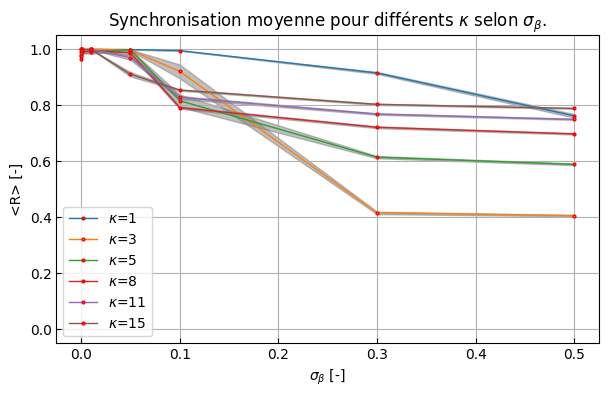

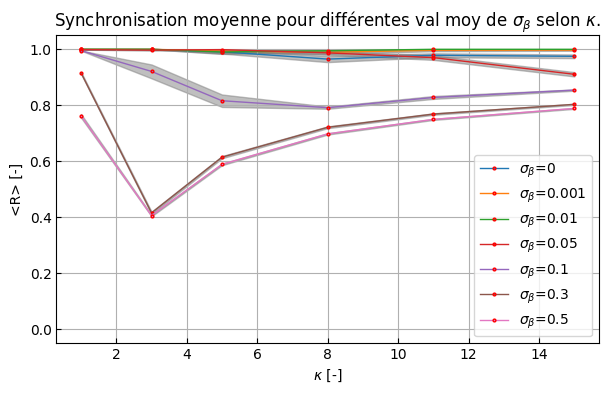

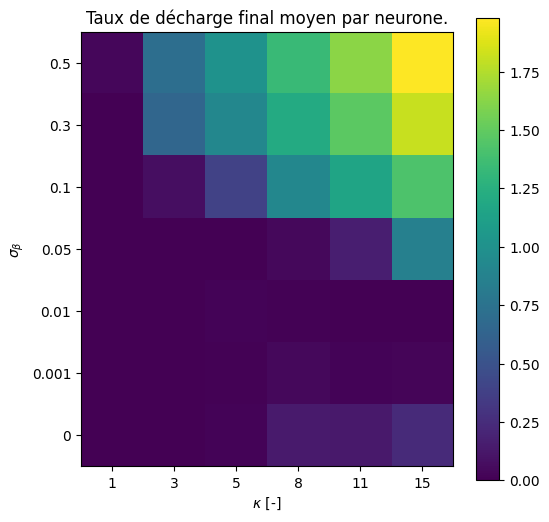

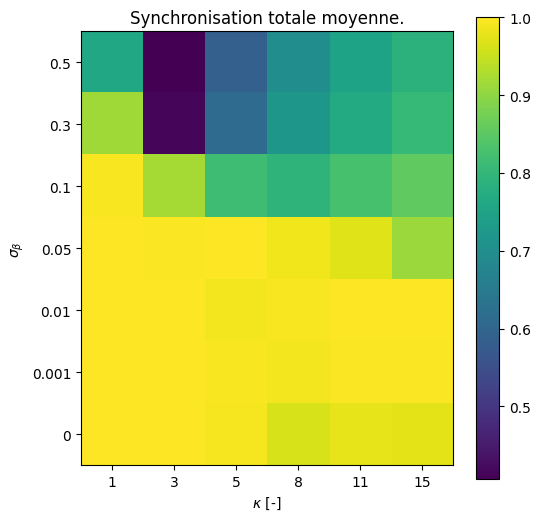

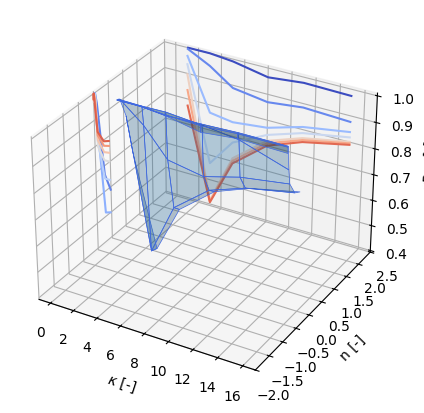

In [384]:
# Dynamique N neurone theta.
N = 100
euler = 0
scipy = 1
mean = 50

kappas = [1, 3, 5, 8, 11, 15]
# kappas = [5, 15]

# n_list = [1, 3, 6, 10, 15, 20]
# n_list = [1, 3, 5, 8, 12]
n_list = [10]

# beta_mean = [-0.5, -0.2, 0, 0.2, 0.5, 0.8, 1]
beta_sigma = [0, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5]
# beta_sigma = [0.001]

f_map = np.zeros((len(kappas), len(beta_sigma)))
# f_map_norm = np.zeros((len(kappas), len(n_list)))
R_map = np.zeros((len(kappas), len(beta_sigma), 2, mean))
for m in range(mean):
    # theta_0 = np.random.normal(np.pi, 1, (N, 1))
    theta_0 = np.random.standard_normal((N, 1))
    # theta_0 = np.random.rand(N, 1)*2*np.pi

    A = np.ones((N, N))#-np.identity(N)
    # A = np.random.normal(0.3, 0.05, (N, N))
    for j, kappa in enumerate(kappas):
        for i, bsigma in enumerate(beta_sigma):

            n = 10
            # beta_0 = -0.5
            beta_0 = np.random.normal(-0.5, bsigma, (N, 1))
            # kappa = 10

            a_n = 2**n*(facto(n))**2/facto(2*n)
            step_approx = 0.01/(2*(0.00001+np.mean(beta_0) + a_n*kappa*2**n))
            
            time_start = 0
            time_step = step_approx
            time_stop = 1000
            time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


            if euler:
                theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, n, beta_0, kappa)
            
            elif scipy:
                sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=1e-10, max_step=0.1, atol = 0, rtol = 1e-8, args = (betaNneurones, A, n, beta_0, kappa))
                time_list, theta = sol.t, sol.y
            
            synchro = indice_syncronisation(theta)
            R, std_modif = half_mean(synchro, time_list, True)
            R_map[j, i, :, m] = np.array([R, std_modif])

            raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
            f_map[j, i] += half_mean(fire_list)/mean
            # f_map_norm[j, i] += half_mean(fire_list_norm)/mean
mean_std = np.std(R_map[:, :, 0, :], axis = 2)
R_map = np.mean(R_map, axis = 3)
R_map[:, :, 1] += mean_std/np.sqrt(mean)

if len(R_map) == 1 and mean == 1:
    if euler:
        fig_sync(time_list, theta)
        # fig_spike_rep(time_list, theta, theta_0)
        spike_rep_euler = spike_rep(theta, 30)/2**30
        raster_plot_array = []
        for neuron in spike_rep_euler:
            raster_plot_array += [time_list[find_peaks(neuron, 0.5)[0]]]
        fig_raster(raster_plot_array, time_stop)
        fig_heatmap(theta)

    # Scipy version
    if scipy:
        raster_plot_scipy, fire_list = raster_and_frate_builder(time_list, theta, time_stop)
        fig_sync_frate(time_list, theta, fire_list, neighbors=10)
        # fig_sync(time_list, theta)
        # fig_frate(fire_list, 10)
        # fig_spike_rep(time_list, theta, theta_0)
        fig_raster(raster_plot_scipy, time_stop)
        # fig_heatmap(theta)

else:
    fig_mean_sync_all(beta_sigma, R_map, kappas, labeltxt=r'$\kappa$', axis = 0, 
                    xlabel=r"$\sigma_\beta$ [-]", 
                    title=fr"Synchronisation moyenne pour différents $\kappa$ selon $\sigma_\beta$.")
    
    fig_mean_sync_all(kappas, R_map, beta_sigma, labeltxt=r'$\sigma_\beta$', 
                    xlabel=r"$\kappa$ [-]", 
                    title=fr"Synchronisation moyenne pour différentes val moy de $\sigma_\beta$ selon $\kappa$.")
    
    fig_mean_frate(f_map, kappas, beta_sigma, yname = r'$\sigma_\beta$')
    # fig_mean_frate(f_map_norm, kappas, n_list, title='Taux de décharge finale moyen normalisé.')

    fig_mean_sync_heat_map(R_map[:, :, 0], kappas, beta_sigma, yname = r'$\sigma_\beta$')
    
    fig_3D(kappas, beta_sigma, R_map)


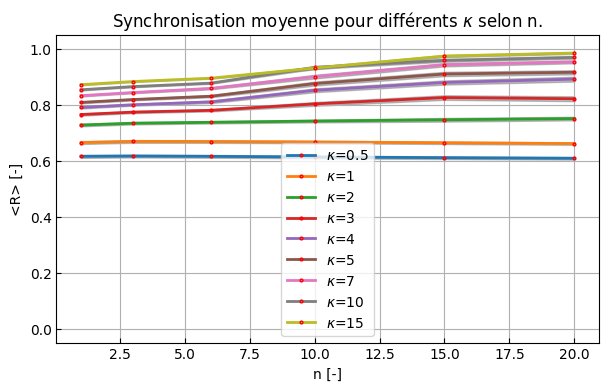

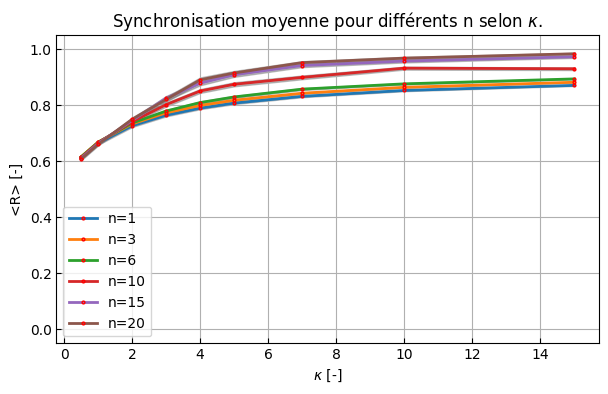

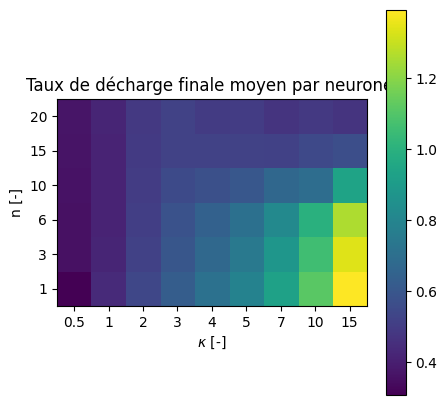

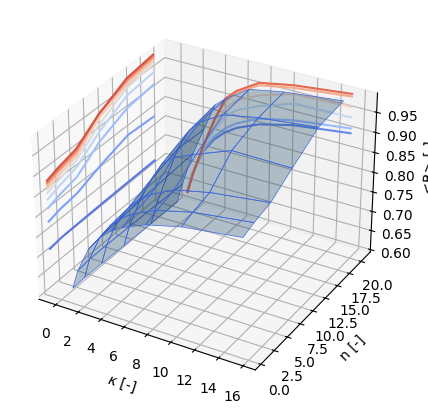

In [251]:
fig_mean_sync_all(n_list, R_map, kappas, labeltxt=r'$\kappa$', axis = 0, 
                xlabel=r"n [-]", 
                title=fr"Synchronisation moyenne pour différents $\kappa$ selon n.")

fig_mean_sync_all(kappas, R_map, n_list, 
                xlabel=r"$\kappa$ [-]", 
                title=fr"Synchronisation moyenne pour différents n selon $\kappa$.")

fig_mean_frate(f_map, kappas, n_list)
# fig_mean_frate(f_map_norm, kappas, n_list, title='Taux de décharge finale moyen normalisé.')

fig_3D(kappas, n_list, R_map)

Networkx
- gnm
- Erdos-Renyi ++
- Configuration model

poid sompolinski

In [ ]:
# Erdos-Renyi exemple by Networkx
n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos, with_labels=True)
plt.show()

In [ ]:
# Configuration model exemple and try about multigraph plot (unsuccesful)
degree_list = [4, 7, 3, 6, 2, 3, 5, 2]
G = nx.configuration_model(degree_list)
graph_degree = int(sum(degree_list)/2)
print(G, graph_degree)

A = np.array(nx.adjacency_matrix(G).toarray())
print(np.sum(A+np.diag(np.diag(A)), axis=1))
print(list(G.edges))

plt.figure(figsize=(12, 6))
nx.draw_networkx(G, style=':', edge_color=tuple(np.linspace(0, 1, graph_degree)),  with_labels=True)
plt.show()

plt.imshow(A, cmap='plasma')
plt.colorbar()
plt.show()

In [ ]:
# Latex code for k_5 graph
G1 = nx.dense_gnm_random_graph(5, 10)
G = nx.complete_graph(5)
A = nx.adjacency_matrix(G)
print(np.array(A.toarray()))
nx.draw_shell(G, with_labels=True)
print(nx.to_latex(G, caption="Pentagrame"))

In [ ]:
G = nx.bipartite.random_graph(15, 10, 0.5)
A = np.array(nx.adjacency_matrix(G).toarray())
print(A)
nx.draw_bipartite(G)